<a href="https://colab.research.google.com/github/mvince33/food-sales-predictions/blob/main/food_sales_prediction_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Food Sales Predictions
- Michael Vincent
- 7/27

## Imports

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn import set_config
set_config(display = 'diagram')

## Load the data

In [2]:
# Load the data
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vRNQ2yuuZKv8cbgh4i4BHnxryjbO8BUviZeIPvva0lIUS23NLolb67KroUgKUOLljhQwxTJZSZrhnyY/pub?output=csv'
df = pd.read_csv(url)

# Check to make sure the data loaded propeprly
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## Explore the data

In [3]:
# Check for duplicates
print('There are', df.duplicated().sum(), 'duplicates in the data set.')

# Check for missing values
print('There are', df.isna().sum().sum(), 'missing values.')

# Find where the missing values are
df.isna().sum()

There are 0 duplicates in the data set.
There are 3873 missing values.


Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

> The columns 'Item_Weight' and 'Outlet_Size' have missing values. These will be imputed before we do any data analysis or machine learning.

In [4]:
# Check for inconsistent labelling
for col in df.columns:
  print(col + ':')
  if df[col].dtype == 'object':
    print(df[col].value_counts())
    print()

Item_Identifier:
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64

Item_Weight:
Item_Fat_Content:
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

Item_Visibility:
Item_Type:
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

Item_MRP:
Outlet_Identifier:
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929

> The 'Item_Fat_Content' has inconsistent labels. We will fix those than make a copy of the DataFrame for machine learning.

In [5]:
# Correct the inconsistent labels in 'Item_Fat_Content'.
df['Item_Fat_Content'].replace(['Low Fat', 'LF', 'low fat', 'reg'],
                               ['Low_Fat', 'Low_Fat', 'Low_Fat', 'Regular'],
                               inplace = True)

# Confirm the changes were made
df['Item_Fat_Content'].value_counts()

Low_Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [6]:
# Make a copy of the DataFrame for machine learning.
ml_df = df.copy()

In [7]:
# Determine the types of data in the data set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


>Numerical Features:
- Item_Weight
- Item_Visibility
- Item_MRP
- Outlet_Establishment_Year
- Item_Outlet_Sales

>Categorical Features:
- Item_Identifier
- Item_Fat_Content
- Item_Type
- Outlet_Identifier
- Outlet_Size
- Outlet_Location_Type
- Outlet_Type

In [8]:
# Get the summary statistics
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


> With the exception of the maximum in Item_Outlet_sales all the quartiles are within three standard deviations of the mean.

## Data Analysis

### Construct Histograms

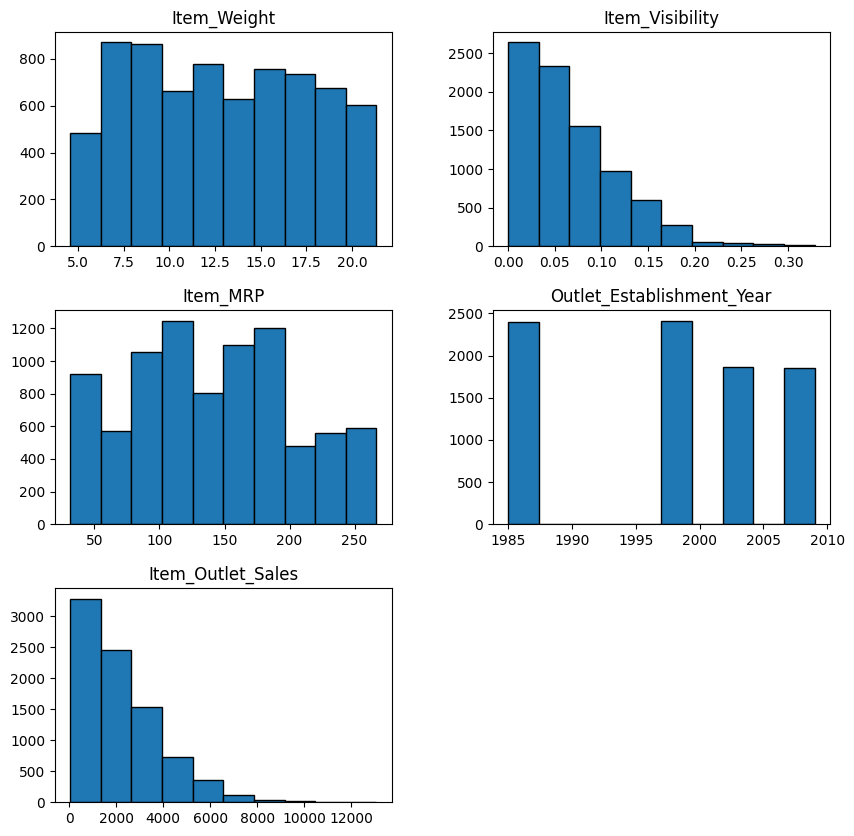

In [9]:
# Make histograms of the numerical data
df.hist(figsize = (10, 10), edgecolor = 'black', grid = False);

> The 'Item_Weight' seems to be fairly uniform. This will not be preserved if we impute with a single value.



### Impute Missing Values

In [10]:
# Show the counts of 'Item_Weights' that are missing values.
filter = df['Item_Weight'].isna()
df.loc[filter, 'Item_Type'].value_counts()

Fruits and Vegetables    213
Snack Foods              212
Household                151
Frozen Foods             138
Dairy                    116
Baking Goods             112
Canned                   110
Health and Hygiene        90
Meat                      88
Soft Drinks               71
Breads                    47
Others                    32
Hard Drinks               31
Breakfast                 21
Starchy Foods             18
Seafood                   13
Name: Item_Type, dtype: int64

In [11]:
# Average each category of 'Item_Weights.'
for item_type in df.loc[filter, 'Item_Type'].value_counts().index:
  item_filter = df['Item_Type'] == item_type
  avg = df.loc[item_filter, 'Item_Weight'].mean()
  print('The average weight of the category', item_type,
        'is:', round(avg, 1))

print()

df.isna().sum()
# Find the mean of each category of 'Item_Weights.'
for item_type in df.loc[filter, 'Item_Type'].value_counts().index:
  item_filter = df['Item_Type'] == item_type
  med = df.loc[item_filter, 'Item_Weight'].median()
  print('The median weight of the category', item_type,
        'is:', round(med, 1))

The average weight of the category Fruits and Vegetables is: 13.2
The average weight of the category Snack Foods is: 13.0
The average weight of the category Household is: 13.4
The average weight of the category Frozen Foods is: 12.9
The average weight of the category Dairy is: 13.4
The average weight of the category Baking Goods is: 12.3
The average weight of the category Canned is: 12.3
The average weight of the category Health and Hygiene is: 13.1
The average weight of the category Meat is: 12.8
The average weight of the category Soft Drinks is: 11.8
The average weight of the category Breads is: 11.3
The average weight of the category Others is: 13.9
The average weight of the category Hard Drinks is: 11.4
The average weight of the category Breakfast is: 12.8
The average weight of the category Starchy Foods is: 13.7
The average weight of the category Seafood is: 12.6

The median weight of the category Fruits and Vegetables is: 13.1
The median weight of the category Snack Foods is: 13.

> The above shows that it is reasonable to impute the missing values in 'Item_Weights' with either the mean or the median. We will choose to use the mean. We will impute the missing values in 'Outlet_Size' with the value 'Missing'.

In [12]:
# Impute the missing values
avg = df['Item_Weight'].mean()
df['Item_Weight'].fillna(avg, inplace = True)
df['Outlet_Size'].fillna('Missing', inplace = True)

# Check to make sure missing values were filled
df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

### Construct Boxplots

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB



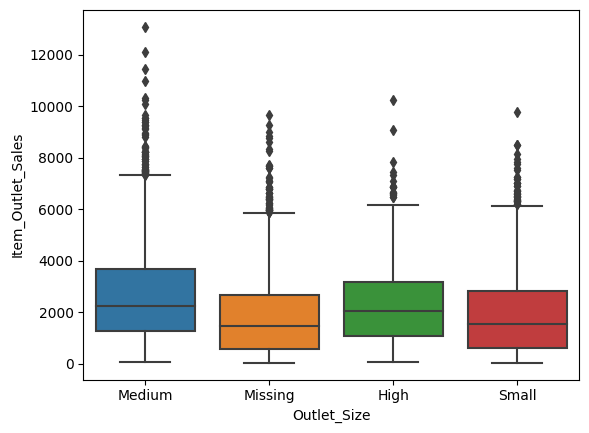

In [13]:
# Construct boxplots for the variables involving the Outlets
df.info()
print()

# Make boxplots for 'Item Outlet Sales' vs. 'Outlet Size'
sns.boxplot(x = 'Outlet_Size', y = 'Item_Outlet_Sales', data = df);

> With the exeception of flagged outliers, the sales are relatively the same by outlet size. Interestingly enough, the outlet size of medium is the highest performing. (But not by much.)

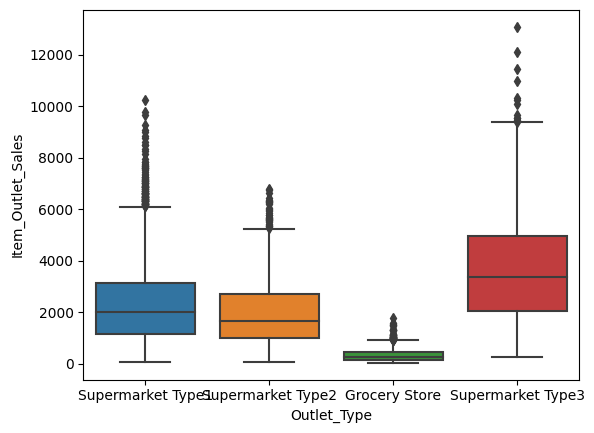

In [14]:
# Make boxplots for 'Item Outlet Sales' vs. 'Outlet_Type'.
sns.boxplot(x = 'Outlet_Type', y = 'Item_Outlet_Sales', data = df);

> These boxplots suggest that grocery stores generate significantly less sales than the supepmarkets.

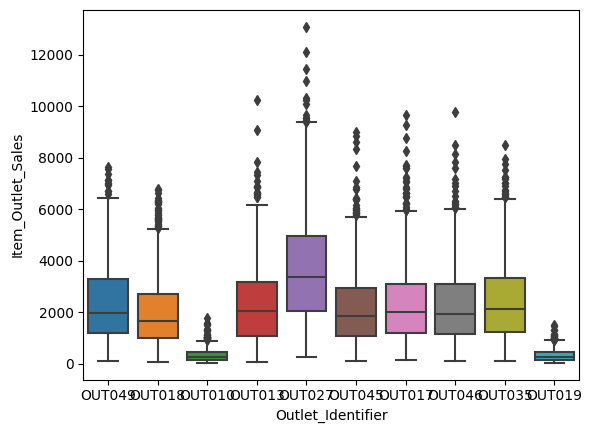

In [15]:
# Make boxplots for 'Item Outlet Sales' vs. 'Outlet Identifier'.
sns.boxplot(x = 'Outlet_Identifier', y = 'Item_Outlet_Sales', data = df);

> These boxplots give sales by outlet identifier.

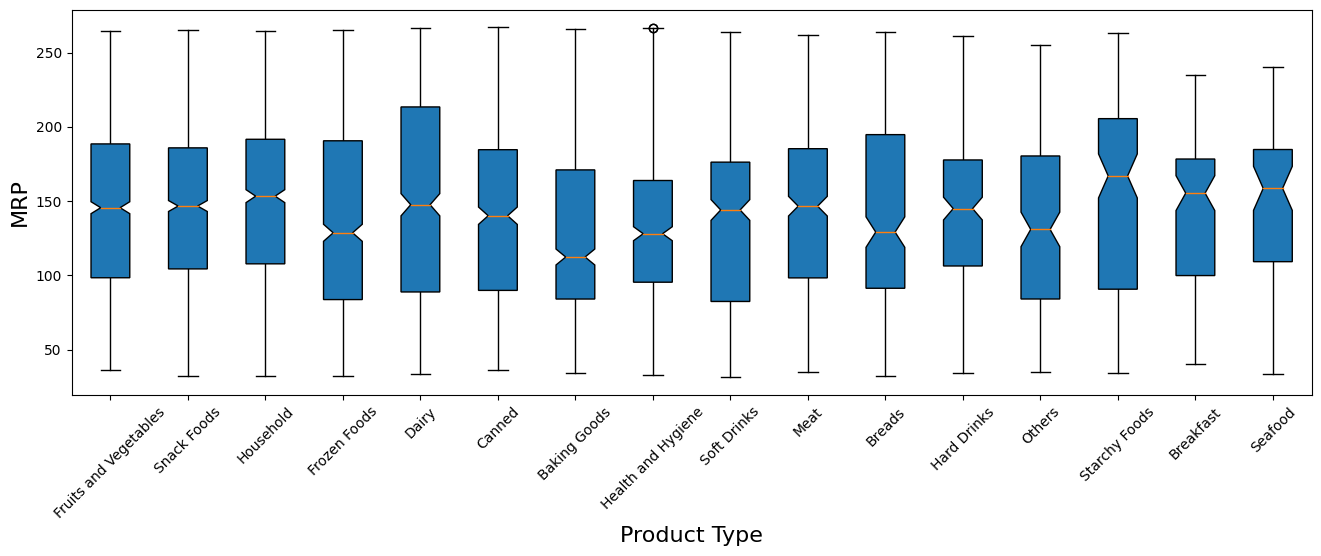

In [16]:
# Boxplots for MRP by item type.

# Get the values to construct boxplots of
food_types = df['Item_Type'].value_counts().index
mrp = [df.loc[df['Item_Type'] == item_type, 'Item_MRP'] for item_type in food_types]

# Construct the boxplots
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (16, 5));
boxplots = axes.boxplot(mrp,
                        labels = food_types,
                        patch_artist = True,
                        notch = True);
plt.xticks(rotation = 45);
plt.xlabel('Product Type', fontsize = 16);
plt.ylabel('MRP', fontsize = 16);

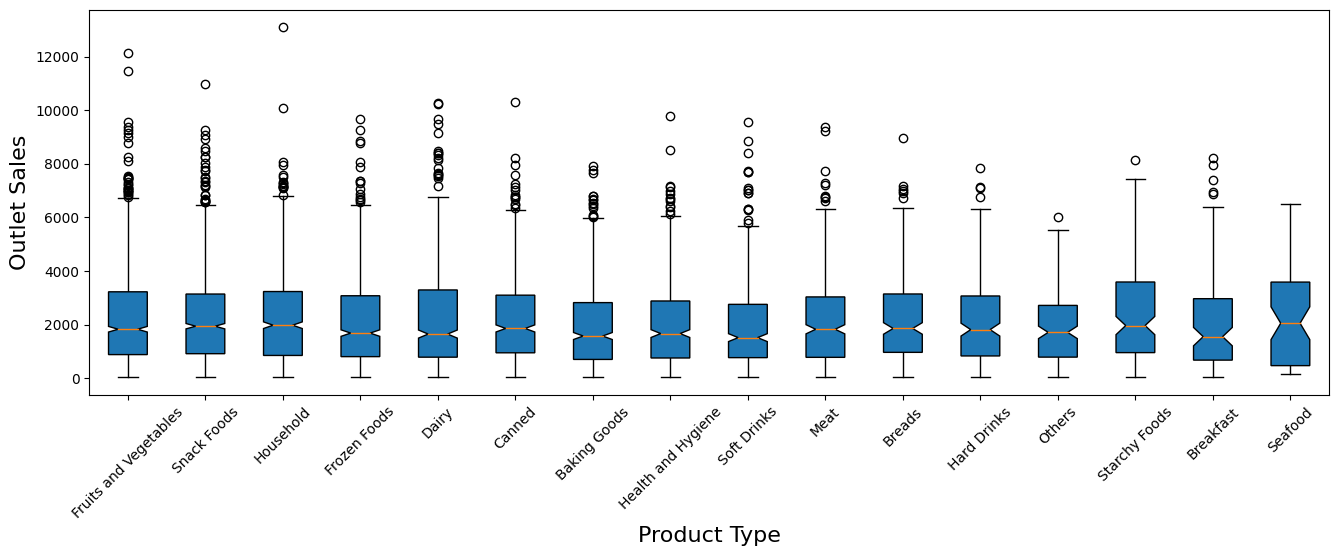

In [17]:
# Construct boxplots for 'Item Type' with the y-axis as 'Item Outlet Sales'.

outlet_sales_by_type = [df.loc[df['Item_Type'] == item_type, 'Item_Outlet_Sales'] for item_type in food_types]
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (16, 5));
boxplots = axes.boxplot(outlet_sales_by_type,
                        labels = food_types,
                        patch_artist = True,
                        notch = True);
plt.xticks(rotation = 45);
plt.xlabel('Product Type', fontsize = 16);
plt.ylabel('Outlet Sales', fontsize = 16);

### Construct a Heatmap

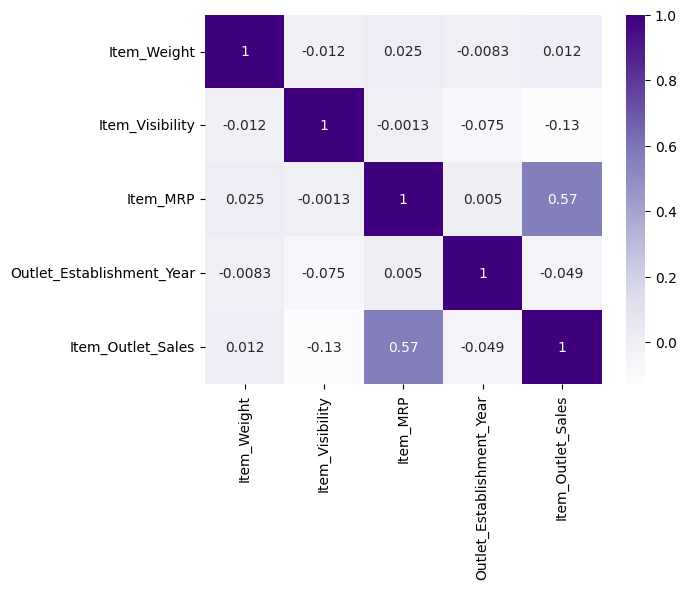

In [18]:
# Construct the heatmap
corr = df.corr()
sns.heatmap(corr, cmap = 'Purples', annot = True);

## Data Interpretation

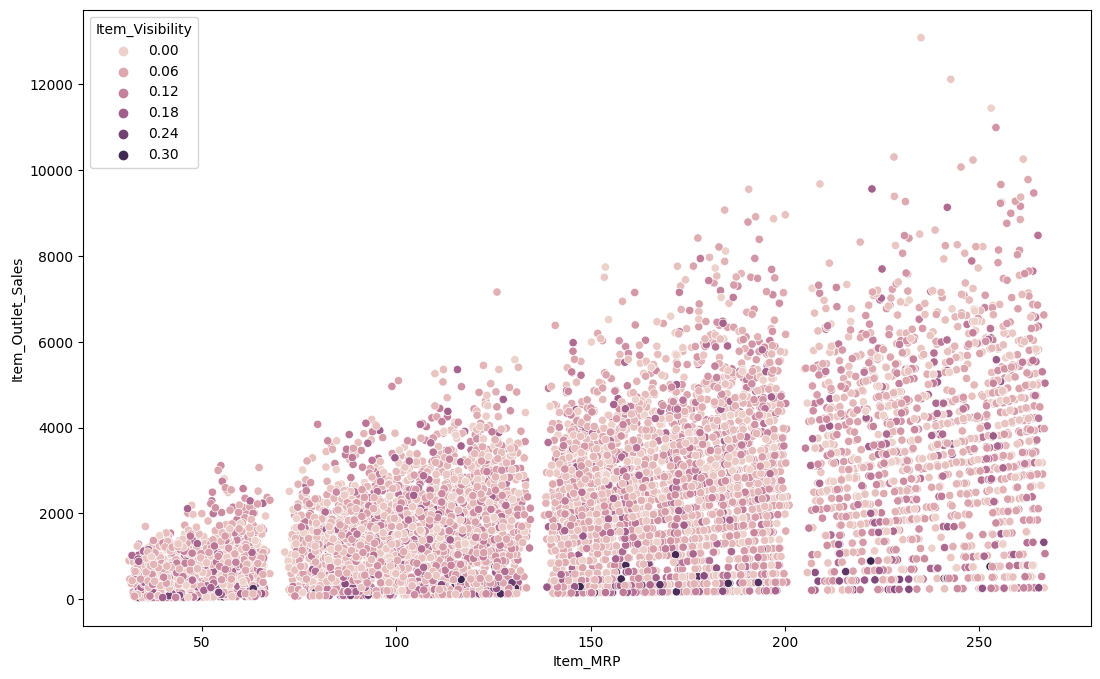

In [19]:
# Create a scatter plot of 'Item_Outlet_Sales' vs. 'Item_MRP'.

plt.figure(figsize = (13, 8));
sns.scatterplot(x = df['Item_MRP'], y = df['Item_Outlet_Sales'], hue = df['Item_Visibility']);

The above scatterplot shows us there is a positive correlation between 'Item_MRP' (manufacturer's retail price?) and sales, where a higher MRP correlates with higher sales. Some caution should be used here as high MRP does not guarantee high sales. The converse is true though. Higher sales correspond with higher MRPs. 

We also used hue to represent the item's visibility. Darker hues correspond with higher visibility, and lighter hues correspond with lower visibility. As we can see on the graph, higher visibility does not correlate with higher sales. Indeed, the highest sales correspond with lower visibilities.

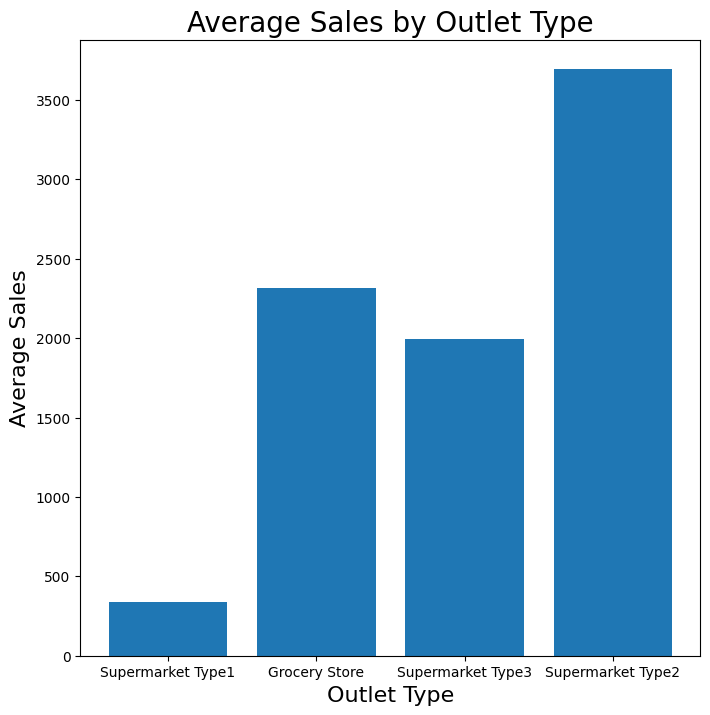

In [20]:
# Construct a bar graph for average sales by outlet type.

# Get the counts of each outlet type
outlet_counts = df['Outlet_Type'].value_counts()
# Get the average sales of each outlet type
cum_sales_by_outlet = df.groupby('Outlet_Type')['Item_Outlet_Sales'].sum() / outlet_counts

# Plot average sales by outlet type
plt.figure(figsize = (8, 8));
plt.bar(df['Outlet_Type'].value_counts().index, cum_sales_by_outlet);
plt.xlabel('Outlet Type', fontsize = 16);
plt.ylabel('Average Sales', fontsize = 16);
plt.title('Average Sales by Outlet Type', fontsize = 20);

>This graph reveals that the average sales _by outlet type_ reveal that grocery stores are not underperforming, it is actually supermarket type 1 that is underperforming.

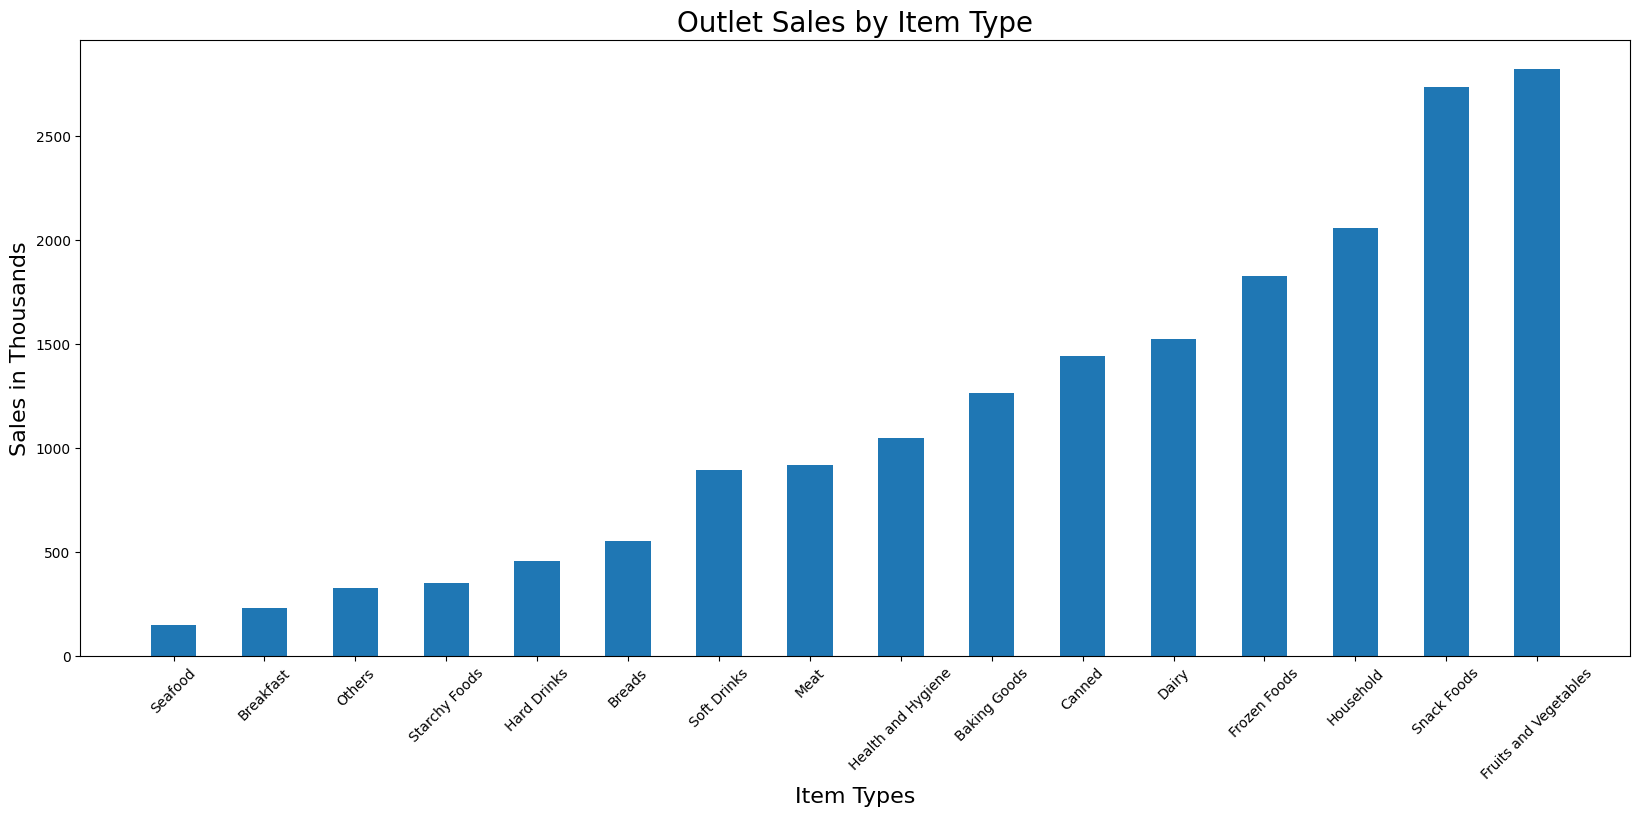

In [21]:
# Make a bar chart for cumulative sales by item type
cum_sales_by_type = df.groupby('Item_Type')['Item_Outlet_Sales'].sum() / 1000
cum_sales_by_type.sort_values(inplace = True)

# Construct the graph
plt.figure(figsize = (20, 8));
plt.bar(cum_sales_by_type.index, cum_sales_by_type, width = 0.5);
plt.xticks(rotation = 45);
plt.xlabel('Item Types', fontsize = 16);
plt.ylabel('Sales in Thousands', fontsize = 16);
plt.title('Outlet Sales by Item Type', fontsize = 20);

>

> This graph orders the sales of each item type from lowest sales to highest sales.

## Data processing

In [22]:
# Confirm the DataFrame set aside for machine learning has no duplicates.
print('Duplicates:', ml_df.duplicated().sum(), '\n')

# Confirm the column with inconsistent labels has been fixed
print(ml_df['Item_Fat_Content'].value_counts(), '\n')

# Note the columns with missing values
ml_df.isna().sum()

Duplicates: 0 

Low_Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64 



Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

### Set the Features and Target

In [23]:
# At the moment we choose to use all columns for
# features except for 'Item_Identifier'.  
features = ['Item_Weight',
            'Item_Fat_Content',
            'Item_Visibility',
            'Item_Type',
            'Item_MRP',
            #'Outlet_Identifier',
            'Outlet_Size',
            'Outlet_Location_Type',
            'Outlet_Type']

In [24]:
# Set the target and features
X = ml_df[features]
y = ml_df['Item_Outlet_Sales']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

### Construct the Pipeline

In [25]:
# Get the data types of our features 
ml_df[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Item_Weight           7060 non-null   float64
 1   Item_Fat_Content      8523 non-null   object 
 2   Item_Visibility       8523 non-null   float64
 3   Item_Type             8523 non-null   object 
 4   Item_MRP              8523 non-null   float64
 5   Outlet_Size           6113 non-null   object 
 6   Outlet_Location_Type  8523 non-null   object 
 7   Outlet_Type           8523 non-null   object 
dtypes: float64(3), object(5)
memory usage: 532.8+ KB


In [26]:
# Build the column selectors
num_selector = make_column_selector(dtype_include = 'number')
cat_selector = make_column_selector(dtype_include = 'object')

# Instantiate the column transformers
scaler = StandardScaler()
ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')

# Instantiate the imputers
mean_imputer = SimpleImputer(strategy = 'mean')
missing_imputer = SimpleImputer(strategy = 'constant', fill_value = 'Missing')

# Instantiate the pipelines
num_pipeline = make_pipeline(mean_imputer, scaler)
cat_pipeline = make_pipeline(missing_imputer, ohe)

# Construct tuples for the column transformer
num_tuple = (num_pipeline, num_selector)
cat_tuple = (cat_pipeline, cat_selector)

# Instantiate the column transformer
preprocessor = make_column_transformer(num_tuple, cat_tuple)

> In the data exploration portion of this notebook we saw that the mean and median for 'Item_Weight' were similar, so it is reasonable to use either value for imputing. We choose to use the mean.

> We choose to impute the missing value for 'Outlet_Size' with missing since we have no reason to draw conclusions about what size the missing values have.

### Process the Data

In [27]:
# Fit the preprocessor
preprocessor.fit(X_train)

# Apply the preprocessor to the data
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

## Construct machine learning models

In [28]:
# Build some helper functions to evaluate metrics
def eval_metrics(actual, predicted):
  """Evaulate R2, MAE, MSE, and RMSE"""
  mae = mean_absolute_error(actual, predicted)
  mse = mean_squared_error(actual, predicted)
  rmse = np.sqrt(mse)
  r2 = r2_score(actual, predicted)
  return mae, mse, rmse, r2

def print_metrics(mae, mse, rmse, r2):
  print(f"MAE: {mae}\nMSE: {mse}\nRMSE: {rmse}\nR2: {r2}")

### Construct a Linear Regression Model

In [29]:
# Instantiate a linear regression model
lin_reg = LinearRegression()
# Fit the model to the processed traning data
lin_reg.fit(X_train_processed, y_train)

LinearRegression()

In [30]:
# Evaluate the linear model on the test set
lin_test_pred = lin_reg.predict(X_test_processed)
print('Test Metrics')
lin_MAE, lin_MSE, lin_RMSE, lin_r2_score = eval_metrics(y_test, lin_test_pred)
print_metrics(lin_MAE, lin_MSE, lin_RMSE, lin_r2_score)
print('\nTrain Metrics')
train_MAE, train_MSE, train_RMSE, train_r2 = eval_metrics(y_train, lin_reg.predict(X_train_processed))
print_metrics(train_MAE, train_MSE, train_RMSE, train_r2)

Test Metrics
MAE: 805.6368259033318
MSE: 1197415.1499798426
RMSE: 1094.2646617614234
R2: 0.5659931108270305

Train Metrics
MAE: 847.0602532540676
MSE: 1298650.907656376
RMSE: 1139.58365540068
R2: 0.5611858945311943


> We already saw from our heatmap that there are not strong linear correlations between the numeric features, so we are not surprised that our linear regression model is somewhat underwhelming.

> Both a decision tree and bagged tree models were constructed. These models were consistently overfitting the training data and were not performing much better than the linear model.

> We will try a random forest in hopes of constructing a more accurate model.

### Construct a Random Forest Model

In [31]:
# Tune the model by max_depth
depths = list(range(1, 50))
cols = ['Test R2',
        'Test MAE',
        'Test MSE',
        'Test RMSE']
scores_rf = pd.DataFrame(index = depths, columns = cols)
for depth in depths:
  rf = RandomForestRegressor(max_depth = depth, random_state = 42)
  rf.fit(X_train_processed, y_train)
  predictions = rf.predict(X_test_processed)
  mae, mse, rmse, r2 = eval_metrics(y_test, predictions)
  scores_rf.loc[depth, 'Test MAE'] = mae
  scores_rf.loc[depth, 'Test MSE'] = mse
  scores_rf.loc[depth, 'Test RMSE'] = rmse
  scores_rf.loc[depth, 'Test R2'] = r2

In [32]:
# Get more hyperparameters for the random forest.
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 49,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [33]:
# Tune the random forest by max_features with a max_depth of 5
param_vals = list(range(1, 50))
scores_rf = pd.DataFrame(index = param_vals, columns = cols)
for val in param_vals:
  rf = RandomForestRegressor(max_depth = 5, n_jobs = val, random_state = 42)
  rf.fit(X_train_processed, y_train)
  predictions = rf.predict(X_test_processed)
  mae, mse, rmse, r2 = eval_metrics(y_test, predictions)
  scores_rf.loc[val, 'Test MAE'] = mae
  scores_rf.loc[val, 'Test MSE'] = mse
  scores_rf.loc[val, 'Test RMSE'] = rmse
  scores_rf.loc[val, 'Test R2'] = r2

- A max_depth of 5 got an r2 of 0.602
- Tuning n_estimators showed no significant improvement.
- Tuning max_leaf_nodes showed no significant improvement.
- Tuning by max_samples showed no significant improvement.
- Tuniny by max_features showed no significant improvement.

### Evaluate the Random Forest Model

In [34]:
# Sort the metrics
scores_rf = scores_rf.sort_values(by = 'Test R2', ascending = False)
display(scores_rf.head(10))

# Display the test and training metrics
print('\nTrain Metrics')
rf = RandomForestRegressor(max_depth = 5, random_state = 42)
rf.fit(X_train_processed, y_train)
mae, mse, rmse, r2 = eval_metrics(y_train, rf.predict(X_train_processed))
print_metrics(mae, mse, rmse, r2)

print('\nTest Metrics')
mae, mse, rmse, r2 = eval_metrics(y_test, rf.predict(X_test_processed))
print_metrics(mae, mse, rmse, r2)

,Test R2,Test MAE,Test MSE,Test RMSE
1,0.602639,728.459402,1096311.336598,1047.04887
26,0.602639,728.459402,1096311.336598,1047.04887
28,0.602639,728.459402,1096311.336598,1047.04887
29,0.602639,728.459402,1096311.336598,1047.04887
30,0.602639,728.459402,1096311.336598,1047.04887
31,0.602639,728.459402,1096311.336598,1047.04887
32,0.602639,728.459402,1096311.336598,1047.04887
33,0.602639,728.459402,1096311.336598,1047.04887
34,0.602639,728.459402,1096311.336598,1047.04887
35,0.602639,728.459402,1096311.336598,1047.04887



Train Metrics
MAE: 755.3712151611321
MSE: 1152550.1103347763
RMSE: 1073.56886613518
R2: 0.6105533498704092

Test Metrics
MAE: 728.4594018507988
MSE: 1096311.336597652
RMSE: 1047.0488702050407
R2: 0.6026385061439912


> After multiple attempts to further tune our random forest we suspect that the accuracy of our model may be limited by the data. If a more accurate model is desired by our client we would reccomend gathering further data. 

> At present, we have a random forest model that is performing similary on the test and train sets with an R2 of about 60%, this says our model accounts for about 60% of the variation in the data. We have a mean absolute error of about $\$728$ dollars in our test set. This says our sales by outlet are off by about $\$730$ on average. Our root mean squared error of about $\$1050$ suggests that there are larger errors being made by our model. This further reinforces the need for more data should a more accurate model be desired.